In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

from simulator.objects.market import Market
from simulator.objects.participant import Participant
from simulator.objects.policies.base_policy import BasePolicy
from simulator.objects.policies.ml_policy import MLPolicy, PassiveAggressivePolicy
from simulator.objects.policies.nn_policy import NNPolicy
from simulator.objects.stock import Portfolio, Stock, StockHolding

rng = default_rng()

In [11]:
def generate_stocks(n_stocks: int) -> list[Stock]:
    output: list[Stock] = []
    for _ in range(n_stocks):
        output.append(
            Stock(
                cash=rng.uniform(-10000, 30000, size=1)[0],
                earning_value_of_assets=rng.uniform(10000, 30000, size=1)[0],
                latest_quarterly_earnings=rng.uniform(10000, 30000, size=1)[0],
                price_history=np.ones(shape=(1825,)) * rng.uniform(10, 200, size=1)[0],
                quality_of_leadership=rng.uniform(0, 1, size=1)[0],
                stock_volatility=rng.uniform(0, 0.1, size=1)[0],
            )
        )
    return output

In [12]:
def generate_portfolio(stocks: list[Stock]) -> Portfolio:
    stock_holdings: list[StockHolding] = []
    for stock in stocks:
        stock_quantity: int = rng.choice(a=np.array([0, 0, 0, 1, 2, 3]), size=1)[0]
        if stock_quantity > 0:
            stock_holdings.append(
                StockHolding(
                    stock=stock,
                    stock_quantity=stock_quantity,
                )
            )
    return Portfolio(stock_holdings=stock_holdings)

In [13]:
def generate_participants(
    n_participants: int, stock_list: list[Stock], market: Market, policy: BasePolicy
) -> list[Participant]:
    output: list[Participant] = []
    for _ in range(n_participants):
        output.append(
            Participant(
                stock_portfolio=generate_portfolio(stock_list),
                policy=policy,
                cash=3000,
            )
        )
    return output

In [14]:
N_STOCKS = 100

market = Market(stocks=generate_stocks(N_STOCKS), interest_rate_apy=0.02)

In [15]:
# for _ in range(5000):
#     for stock in market.stocks:
#         stock.step()

In [16]:
# for i in range(50):
#     print(market.stocks[i].cash, market.stocks[i].earning_value_of_assets, market.stocks[i].quality_of_leadership)

In [17]:
market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            NNPolicy(
                market=market,
                n_stocks_to_sample=30,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("model2.pt"),
                valuation_model_noise_std=0.05,
            ),
        )[0]
        for _ in range(20)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            NNPolicy(
                market=market,
                n_stocks_to_sample=30,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("model_high_prices.pt"),
                valuation_model_noise_std=0.05,
            ),
        )[0]
        for _ in range(20)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            MLPolicy(
                market=market,
                n_stocks_to_sample=50,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("random_forest_regressor.pkl"),
            ),
        )[0]
        for _ in range(5)
    ]
)

market.add_participants(
    [
        generate_participants(
            1,
            market.stocks,
            market,
            PassiveAggressivePolicy(
                market=market,
                n_stocks_to_sample=50,
                max_stocks_per_timestep=10,
                valuation_model_path=Path("passive_aggressive.pkl"),
            ),
        )[0]
        for _ in range(5)
    ]
)

In [18]:
N_TIMESTEPS = 365

for i in range(N_TIMESTEPS):
    print(i)
    market.step_market()

0
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
Number of buy order stocks: 47
Number of sell order stocks: 64
Market total value: 10332.867186034833
1
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
Number of buy order stocks: 49
Number of sell order stocks: 71
Market total value: 11958.277063579233
2
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
Number of buy order stocks: 45
Number of sell order stocks: 72
Market total value: 13196.40937889452
3
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
Number of buy order stocks: 49
Number of sell order stocks: 80
Market total value: 16459.864448379558
4
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
3

KeyboardInterrupt: 

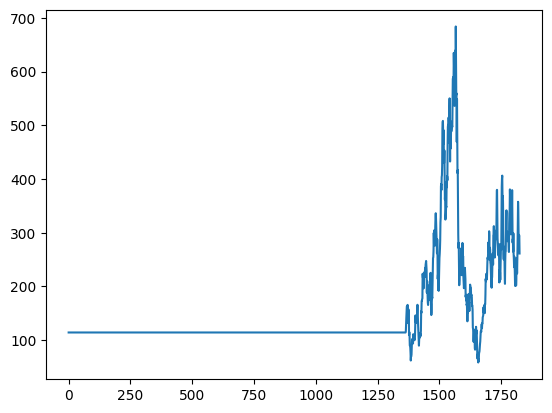

In [ ]:
i = 28

plt.plot(market.stocks[i].price_history)

[1.36258376e+02 1.39004278e+02 1.34277237e+02 ... 6.66066803e+05
 6.62264563e+05 6.79655754e+05]


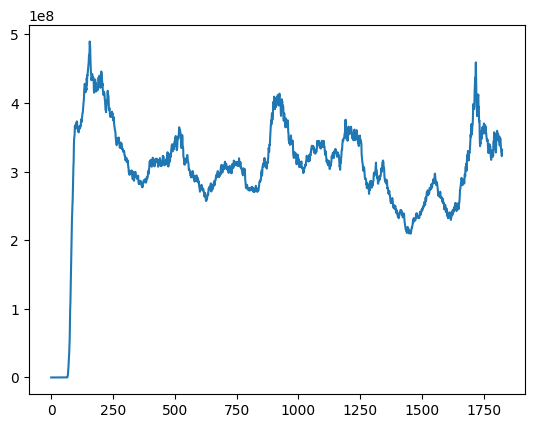

In [ ]:
i = 19

plt.plot(market.participants[i].total_value)
print(market.participants[i].stock_portfolio.get_stock_holding_list()[-7].stock.price_history)

In [ ]:

for i in range(50):
    print(market.stocks[i].earning_value_of_assets, market.stocks[i].quality_of_leadership)

657.9548387809441 0.3018138180391414
4457.140140737732 0.6622446030022725
19670.22509242381 0.45306590425340787
13670.133414879274 0.3794716188911039
10266.474543958562 0.5724032290742946
-174.32224105623442 0.48494357007060374
6194.04461700819 0.7983238066776939
23917.59593279215 0.847639855231275
-2319.9680389550995 0.016141576975619798
9557.936691433191 0.3332328041523015
14688.329187188698 0.4935311463819976
-1654.2490695461288 0.5429031650702135
17002.9278055008 0.8249749304991112
-58.783465635087126 0.5737353892651734
2789.397146835043 0.4524686898728102
37120.768465111374 0.7733713657274781
11756.533573775416 0.7605807893288058
8273.349032290926 0.24816212576926566
21623.449301455457 0.8874667094357437
17277.168194323007 0.6836850782932198
-2299.644396935934 0.30713267428787483
7622.412618589238 0.4738386308757905
6375.758799138409 0.8270792761262065
6256.985687496436 0.3206556474980796
17285.962832865367 0.43044366362481246
15309.047808135107 0.5132222946091053
1435.75213350109